# Setup

In [1]:
%cd sklearn-pmml-model

C:\Users\user\Desktop\ANSON\Python Scripts\SHRDC-projects\knime-examples\sklearn-pmml-model


In [2]:
import os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix

# from pypmml import Model

from sklearn_pmml_model.tree import PMMLTreeClassifier

from sklearn2pmml import sklearn2pmml

In [3]:
# show all columns
pd.set_option('display.max_columns', None)

In [4]:
# setup paths to the files
TRAIN_CSV = os.path.join('..', 'data', 'ChurnPrediction_TrainingSet.xlsx')
TEST_CSV = os.path.join('..', 'data', 'ChurnPrediction_TestSet.xlsx')
print(os.path.exists(TRAIN_CSV))
print(os.path.exists(TEST_CSV))

True
True


In [5]:
train_df = pd.read_excel(TRAIN_CSV)
train_df.head()

C:\Users\user\anaconda3\envs\pmml\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,VMail Message,Day Mins,Eve Mins,Night Mins,Intl Mins,CustServ Calls,Day Calls,Day Charge,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,Area Code,Phone,Account Length,Churn,Int'l Plan,VMail Plan,State
0,25,265.1,197.4,244.7,10.0,1,110,45.07,99,16.78,91,11.01,3,2.70,415,382-4657,128,0,0,1,KS
1,26,161.6,195.5,254.4,13.7,1,123,27.47,103,16.62,103,11.45,3,3.70,415,371-7191,107,0,0,1,OH
2,0,243.4,121.2,162.6,12.2,0,114,41.38,110,10.30,104,7.32,5,3.29,415,358-1921,137,0,0,0,NJ
3,0,299.4,61.9,196.9,6.6,2,71,50.90,88,5.26,89,8.86,7,1.78,408,375-9999,84,0,1,0,OH
4,0,166.7,148.3,186.9,10.1,3,113,28.34,122,12.61,121,8.41,3,2.73,415,330-6626,75,0,1,0,OK


In [6]:
test_df = pd.read_excel(TEST_CSV)
test_df.head()

C:\Users\user\anaconda3\envs\pmml\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,VMail Message,Day Mins,Eve Mins,Night Mins,Intl Mins,CustServ Calls,Day Calls,Day Charge,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,Area Code,Phone,Account Length,Churn,Int'l Plan,VMail Plan,State
0,0,157.0,103.1,211.8,7.1,0,79,26.69,94,8.76,96,9.53,6,1.92,415,329-9001,147,0,1,0,MO
1,37,258.6,222.0,326.4,11.2,0,84,43.96,111,18.87,97,14.69,5,3.02,415,330-8173,141,0,1,1,WV
2,0,187.7,163.4,196.0,9.1,0,127,31.91,148,13.89,94,8.82,5,2.46,415,344-9403,74,0,0,0,RI
3,0,332.9,317.8,160.6,5.4,4,67,56.59,97,27.01,128,7.23,9,1.46,415,351-7269,161,1,0,0,NY
4,27,196.4,280.9,89.3,13.8,1,139,33.39,90,23.88,75,4.02,4,3.73,408,350-8884,85,0,0,1,ID


In [7]:
# Phone and State columns are both nominal (categorical) columns
train_df.dtypes

VMail Message       int64
Day Mins          float64
Eve Mins          float64
Night Mins        float64
Intl Mins         float64
CustServ Calls      int64
Day Calls           int64
Day Charge        float64
Eve Calls           int64
Eve Charge        float64
Night Calls         int64
Night Charge      float64
Intl Calls          int64
Intl Charge       float64
Area Code           int64
Phone              object
Account Length      int64
Churn               int64
Int'l Plan          int64
VMail Plan          int64
State              object
dtype: object

In [8]:
# the dataset is very imbalanced
train_df['Churn'].value_counts()

0    2280
1     386
Name: Churn, dtype: int64

In [9]:
# prepare the training and test set
X_train1 = train_df.drop(columns=["Churn"])
y_train1 = train_df["Churn"].copy()

X_test1 = test_df.drop(columns=["Churn"])
y_test1 = test_df["Churn"].copy()

In [10]:
len(X_train1), len(X_test1)

(2666, 667)

In [11]:
# check unique values in each column
X_train1.nunique()

VMail Message       44
Day Mins          1491
Eve Mins          1460
Night Mins        1426
Intl Mins          159
CustServ Calls      10
Day Calls          117
Day Charge        1491
Eve Calls          119
Eve Charge        1316
Night Calls        114
Night Charge       872
Intl Calls          20
Intl Charge        159
Area Code            3
Phone             2666
Account Length     208
Int'l Plan           2
VMail Plan           2
State               51
dtype: int64

In [12]:
# change the nominal columns into encoded numbers
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_train1[["Phone", "State"]] = encoder.fit_transform(X_train1[["Phone", "State"]])
X_test1[["Phone", "State"]] = encoder.transform(X_test1[["Phone", "State"]])

# Test KNIME Decision Tree Model

In [13]:
# read the KNIME model
KNIME_MODEL_PATH = os.path.join('..', 'models', 'knime_decision_tree.pmml')
knime_model = PMMLTreeClassifier(pmml=KNIME_MODEL_PATH)

In [14]:
y_pred1 = knime_model.predict(X_test1)
y_pred1 = y_pred1.astype(int)
y_pred1.shape

(667,)

In [15]:
total_correct = np.sum(np.where(y_pred1 == y_test1, 1, 0))
total_incorrect = len(y_test1) - total_correct
acc = total_correct / len(y_test1) * 100
error = 100 - acc

In [16]:
# saving results
knime_dt = {
    "Testing accuracy": acc,
    "Correct classified": total_correct,
    "Wrong classified": total_incorrect,
    "Error": error
}
knime_dt

{'Testing accuracy': 92.50374812593704,
 'Correct classified': 617,
 'Wrong classified': 50,
 'Error': 7.496251874062963}

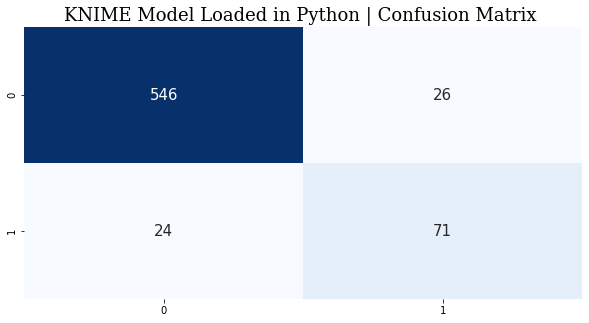

Correct classified: 617			Wrong classified: 50
Accuracy: 92.504 %			Error: 7.496 %


In [17]:
cm = confusion_matrix(y_pred1, y_test1)

fig = plt.figure(figsize=(10, 5))
ax = sns.heatmap(
    cm,
    # use specific color
    cmap="Blues",
    # show numbers
    annot=True,
    # format to integer
    fmt="d",
    # don't show colorbar
    cbar=False,
    # format them to look nicer
    annot_kws={"fontsize": 15},
)
plt.title("KNIME Model Loaded in Python | Confusion Matrix ", size=18, fontfamily="serif")
plt.show()

print(f"Correct classified: {total_correct:,}", end="\t\t\t")
print(f"Wrong classified: {total_incorrect:,}")
print(f"Accuracy: {acc:.3f} %", end="\t\t\t")
print(f"Error: {error:.3f} %")

Original result from KNIME:

![original_KNIME_confusion_matrix](results/decision_tree-confusion_matrix-knime.jpeg)

In [18]:
# saving original KNIME results
knime_dt_ori = {
    "Testing accuracy": 92.954,
    "Correct classified": 620,
    "Wrong classified": 47,
    "Error": 7.046
}

# Prepare data for Python Model

In [19]:
# Get the data again
X_train2 = train_df.drop(columns=["Churn"])
y_train2 = train_df["Churn"].copy()

X_test2 = test_df.drop(columns=["Churn"])
y_test2 = test_df["Churn"].copy()

Decision Tree Parameters in image below. 

Refer to the official KNIME Docs [here](https://hub.knime.com/knime/extensions/org.knime.features.base/latest/org.knime.base.node.mine.decisiontree2.learner2.DecisionTreeLearnerNodeFactory3) for parameters details.

Refer to `sklearn` docs [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)


![knime decision tree parameters](data/knime_decision_tree_params.jpeg)

- Reduced error pruning cannot be specified easily
- Quality measure of "Gini Index" is the default in `sklearn` library in Python
- Min number records per node can be changed easily in `sklearn`
- Number records to store for view is just for visualization purpose, thus not necessary
- Average split point should be the default in `sklearn`
- Number threads is just to use more CPU cores to speed up training
- Skip nominal columns without domain information is based on the cardinality (number of unique values) of each column. In the docs, KNIME did not specifically mentioned what is the minimum required cardinality for excluding any nominal column. But most likely only `Phone` column is excluded as there are 2666 unique values. (see outputs below)
- Binary nominal splits should be the default in `sklearn`
- Max #nominal cannot be modified easily in `sklearn`

In [20]:
cardinality_df = X_train2.nunique().to_frame("Cardinality")
cardinality_df['Type'] = ['Numerical'] * len(cardinality_df)
cardinality_df.loc[['Phone', 'Area Code', 'State'], 'Type'] = 'Nominal'
print("Cardinality of each column (including both numerical and nominal columns):\n")
cardinality_df.sort_values(by='Type')

Cardinality of each column (including both numerical and nominal columns):



,Cardinality,Type
State,51,Nominal
Phone,2666,Nominal
Area Code,3,Nominal
Int'l Plan,2,Numerical
Account Length,208,Numerical
Intl Charge,159,Numerical
Intl Calls,20,Numerical
Night Charge,872,Numerical
Night Calls,114,Numerical
VMail Message,44,Numerical


In [21]:
print("Cardinality of nominal columns:\n")
cardinality_df.query("Type == 'Nominal'")

Cardinality of nominal columns:



,Cardinality,Type
Area Code,3,Nominal
Phone,2666,Nominal
State,51,Nominal


In [22]:
X_train2.drop(columns=['Phone', 'State', 'Area Code'], inplace=True)
X_test2.drop(columns=['Phone', 'State', 'Area Code'], inplace=True)

## Training with sklearn in Python

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn2pmml.pipeline import PMMLPipeline

from sklearn_pandas import DataFrameMapper
from sklearn2pmml.decoration import ContinuousDomain

dt = DecisionTreeClassifier(
    random_state=42,
    criterion="gini", # Quality measure
    min_samples_leaf=6, # Min number records per node
)

# encoder2 = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

pipeline = PMMLPipeline([
    ("classifier", dt)
])

In [24]:
pipeline.fit(X_train2, y_train2)

PMMLPipeline(steps=[('classifier', DecisionTreeClassifier(min_samples_leaf=6, random_state=42))])

In [25]:
y_pred2 = pipeline.predict(X_test2)
y_pred2.shape

(667,)

In [26]:
total_correct = np.sum(np.where(y_pred2 == y_test2, 1, 0))
total_incorrect = len(y_test2) - total_correct
acc = total_correct / len(y_test2) * 100
error = 100 - acc

In [27]:
# saving results
python_dt = {
    "Testing accuracy": acc,
    "Correct classified": total_correct,
    "Wrong classified": total_incorrect,
    "Error": error
}
python_dt

{'Testing accuracy': 93.7031484257871,
 'Correct classified': 625,
 'Wrong classified': 42,
 'Error': 6.296851574212894}

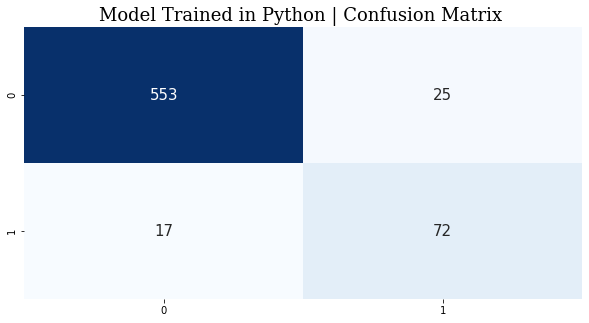

Correct classified: 625					Wrong classified: 42
Accuracy: 93.703 %					Error: 6.297 %


In [28]:
cm = confusion_matrix(y_pred2, y_test2)

fig = plt.figure(figsize=(10, 5))
ax = sns.heatmap(
    cm,
    # use specific color
    cmap="Blues",
    # show numbers
    annot=True,
    # format to integer
    fmt="d",
    # don't show colorbar
    cbar=False,
    # format them to look nicer
    annot_kws={"fontsize": 15},
)
plt.title("Model Trained in Python | Confusion Matrix ", size=18, fontfamily="serif")
plt.show()

print(f"Correct classified: {total_correct:,}", end="\t\t\t\t\t")
print(f"Wrong classified: {total_incorrect:,}")
print(f"Accuracy: {acc:.3f} %", end="\t\t\t\t\t")
print(f"Error: {error:.3f} %")

# Export sklearn model to PMML

In [72]:
from sklearn2pmml import sklearn2pmml

PYTHON_MODEL_PATH = os.path.join("..", "models", "python_decision_tree.pmml")
sklearn2pmml(pipeline, PYTHON_MODEL_PATH, with_repr=True)

C:\Users\user\anaconda3\envs\pmml\lib\subprocess.py:848: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)
C:\Users\user\anaconda3\envs\pmml\lib\subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


In [30]:
# try reading the model
pipeline = PMMLTreeClassifier(pmml=PYTHON_MODEL_PATH)

In [31]:
y_pred3 = pipeline.predict(X_test2)
y_pred3.shape

(667,)

In [32]:
total_correct = np.sum(np.where(y_pred3 == y_test2, 1, 0))
total_incorrect = len(y_test2) - total_correct
acc = total_correct / len(y_test2) * 100
error = 100 - acc

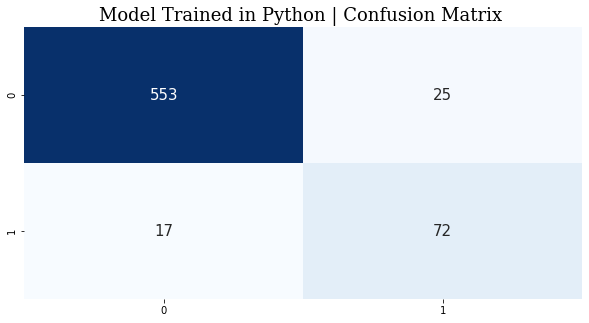

Correct classified: 625					Wrong classified: 42
Accuracy: 93.703 %					Error: 6.297 %


In [33]:
cm = confusion_matrix(y_pred3, y_test2)

fig = plt.figure(figsize=(10, 5))
ax = sns.heatmap(
    cm,
    # use specific color
    cmap="Blues",
    # show numbers
    annot=True,
    # format to integer
    fmt="d",
    # don't show colorbar
    cbar=False,
    # format them to look nicer
    annot_kws={"fontsize": 15},
)
plt.title("Model Trained in Python | Confusion Matrix ", size=18, fontfamily="serif")
plt.show()

print(f"Correct classified: {total_correct:,}", end="\t\t\t\t\t")
print(f"Wrong classified: {total_incorrect:,}")
print(f"Accuracy: {acc:.3f} %", end="\t\t\t\t\t")
print(f"Error: {error:.3f} %")

## Conclusion:

Trained in Python, exported to PMML, loaded back and obtained the same results.

# Overall comparison

In [34]:
import pandas as pd

results_df = pd.DataFrame([python_dt, knime_dt, knime_dt_ori], index=['Python - Decision Tree', 'KNIME - Loaded in Python', 'KNIME - Original'])
results_df

,Testing accuracy,Correct classified,Wrong classified,Error
Python - Decision Tree,93.703148,625,42,6.296852
KNIME - Loaded in Python,92.503748,617,50,7.496252
KNIME - Original,92.954000,620,47,7.046000


In [45]:
style_dict = {"Testing accuracy": '{:,.3f} %',
              "Correct classified": '{:,}',
              "Error": '{:,.3f} %'
             }

results_df.style.background_gradient(cmap='Blues', axis='columns').format(style_dict)

,Testing accuracy,Correct classified,Wrong classified,Error
Python - Decision Tree,93.703 %,625,42,6.297 %
KNIME - Loaded in Python,92.504 %,617,50,7.496 %
KNIME - Original,92.954 %,620,47,7.046 %


In [37]:
RESULT_PATH = os.path.join("..", "results", "overall_comparison-decision_tree.csv")
results_df.to_csv(RESULT_PATH)

# Combine with MNIST results

In [48]:
MNIST_RESULT_PATH = os.path.join("..", "results", "overall_MNIST_result.csv")
mnist_results = pd.read_csv(MNIST_RESULT_PATH, index_col=0)
mnist_results

,Training accuracy,Validation accuracy,Correct classified,Wrong classified,Error
Adadelta Python,97.10,95.000000,1425,75,5.000000
Adadelta KNIME,99.50,93.867000,1408,92,6.133000
Adam Python,99.41,96.333333,1445,55,3.666667
Adam KNIME,99.50,96.533000,1448,52,3.467000


In [52]:
results_df.insert(0, 'Training accuracy', np.nan)

In [60]:
mnist_results.rename(columns={"Validation accuracy": "Testing accuracy"}, inplace=True)

In [61]:
all_results = pd.concat([mnist_results, results_df], axis=0)
all_results

,Training accuracy,Testing accuracy,Correct classified,Wrong classified,Error
Adadelta Python,97.10,95.000000,1425,75,5.000000
Adadelta KNIME,99.50,93.867000,1408,92,6.133000
Adam Python,99.41,96.333333,1445,55,3.666667
Adam KNIME,99.50,96.533000,1448,52,3.467000
Python - Decision Tree,NaN,93.703148,625,42,6.296852
KNIME - Loaded in Python,NaN,92.503748,617,50,7.496252
KNIME - Original,NaN,92.954000,620,47,7.046000


In [64]:
style_dict = {"Testing accuracy": '{:,.3f} %',
              "Correct classified": '{:,}',
              "Error": '{:,.3f} %'
             }

all_results.style.background_gradient(cmap='Blues', axis=1).format(style_dict)

,Training accuracy,Testing accuracy,Correct classified,Wrong classified,Error
Adadelta Python,97.100000,95.000 %,"1,425",75,5.000 %
Adadelta KNIME,99.500000,93.867 %,"1,408",92,6.133 %
Adam Python,99.410000,96.333 %,"1,445",55,3.667 %
Adam KNIME,99.500000,96.533 %,"1,448",52,3.467 %
Python - Decision Tree,nan,93.703 %,625,42,6.297 %
KNIME - Loaded in Python,nan,92.504 %,617,50,7.496 %
KNIME - Original,nan,92.954 %,620,47,7.046 %
